In [83]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
from io import StringIO
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import statsmodels.api as sm
from statsmodels.tools import add_constant
import numpy as np
from statsmodels.base.model import LikelihoodModel
from statsmodels.regression.linear_model import OLS
from statsmodels.multivariate.manova import MANOVA
from statsmodels.multivariate.multivariate_ols import _MultivariateOLS
import statsmodels.multivariate.tests.results as path
from sklearn.model_selection import train_test_split
import matplotlib as plt
import sys
sys.path.append(r'\code')
from LinearRegDiagnostic import LinearRegDiagnostic

In [72]:
import os
cwd = os.getcwd()
print(cwd)

c:\personal\Potsdam\masters\winse_24-25\AIBAS\AI-CPS


In [3]:
##DATA-SCRAPING

# Raw URL of the Markdown file
# raw_url = "https://raw.githubusercontent.com/osman-mohmmed/aibas/refs/heads/main/data/churn_output_new.md"
url ='https://raw.githubusercontent.com/osman-mohmmed/aibas/refs/heads/main/data/churn_dataset_new.md'

# Step 1: Fetch the Markdown content
response = requests.get(url)
response.raise_for_status()
md_content = response.text

# Step 2: Manually process the Markdown table
# Split the content into lines
lines = md_content.splitlines()

# Find the start of the table (look for |---|)
table_start = -1
for i, line in enumerate(lines):
    if '|---' in line:
        table_start = i - 1  # Header is the line before this
        break

if table_start == -1:
    print("No table found in the Markdown file.")
else:
    # Extract the table lines
    table_lines = lines[table_start:]
    table_text = "\n".join(table_lines)

    # Use pandas to parse the table
    df = pd.read_csv(StringIO(table_text), sep="|").iloc[:, 1:-1]  # Trim empty columns
  
df.describe()


,customerID,tenure,InternetService,OnlineSecurity,TechSupport,Contract,PaymentMethod,Churn
count,7044,7044,7044,7044,7044,7044,7044,7044
unique,7044,74,4,4,4,4,5,3
top,:-------------,1,Fiber optic,No,No,Month-to-month,Electronic check,No
freq,1,613,3096,3498,3473,3875,2365,5174


In [ ]:
''' Preprocessing:
    1-DATA-CLEANING '''

#delete noisy chacters ':----'

df.drop(df[df[' customerID   '] == ':-------------'].index,inplace= True)

#strip whitspace from columns name
df.columns = df.columns.str.replace(' ','')
#drop customerId column
df.drop('customerID', axis= 1, inplace=True)



df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 1 to 7043
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tenure           7043 non-null   object
 1   InternetService  7043 non-null   object
 2   OnlineSecurity   7043 non-null   object
 3   TechSupport      7043 non-null   object
 4   Contract         7043 non-null   object
 5   PaymentMethod    7043 non-null   object
 6   Churn            7043 non-null   object
dtypes: object(7)
memory usage: 385.3+ KB


In [ ]:
'''Data type '''
#convert to numeric
# num_clos = ['tenure']
# df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
# df[num_clos] = df[num_clos].apply(pd.to_numeric)

#lable encoding
# df['Churn'] = LabelEncoder().fit_transform(df['Churn'])


#object columns encoding
# obj_clos = df.select_dtypes(include=['object']).columns
# df_encoded = pd.get_dummies(df, columns=obj_clos)



# Display the one-hot encoded DataFrame
# print("One-Hot Encoded DataFrame:")
# print(df_encoded)

#remove whitespace from columns names
# df_encoded.columns = df_encoded.columns.str.replace(' ','')

#convert data type to int 
# df_encoded = df_encoded.astype(int)

#handeling missing values
df_encoded[df_encoded.isna().any(axis=1)]
#drop missing values
df_encoded.dropna(inplace=True)

#check missing values
df_encoded[df_encoded.isna().any(axis=1)]

#detect outliers with zscores
zs = stats.zscore(df_encoded)
zs_ind = abs(zs) > 2.1

#IQR 
Q1 = df_encoded.quantile(0.25)
Q3 = df_encoded.quantile(0.75)
IQR = Q3 - Q1
df_filtered = df_encoded[~((df_encoded < (Q1 - 10 * IQR)) | (df_encoded > (Q3 + 10 * IQR))).any(axis=1)]

# Min-Max Normalization
df_normalized = (df_encoded - df_encoded.min()) / (df_encoded.max() - df_encoded.min())

df_encoded.describe()

,tenure,Churn,InternetService_DSL,InternetService_Fiberoptic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Nointernetservice,OnlineSecurity_Yes,TechSupport_No,TechSupport_Nointernetservice,TechSupport_Yes,Contract_Month-to-month,Contract_Oneyear,Contract_Twoyear,PaymentMethod_Banktransfer(automatic),PaymentMethod_Creditcard(automatic),PaymentMethod_Electroniccheck,PaymentMethod_Mailedcheck
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,0.265370,0.343746,0.439585,0.216669,0.496663,0.216669,0.286668,0.493114,0.216669,0.290217,0.550192,0.209144,0.240664,0.219225,0.216101,0.335794,0.228880
std,24.559481,0.441561,0.474991,0.496372,0.412004,0.500024,0.412004,0.452237,0.499988,0.412004,0.453895,0.497510,0.406726,0.427517,0.413751,0.411613,0.472301,0.420141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
'''Modeling
    1| OLS Model'''


features = ['tenure', 'InternetService_DSL', 'InternetService_Fiberoptic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_Nointernetservice', 'OnlineSecurity_Yes',
       'TechSupport_No', 'TechSupport_Nointernetservice', 'TechSupport_Yes',
       'Contract_Month-to-month', 'Contract_Oneyear', 'Contract_Twoyear',
       'PaymentMethod_Banktransfer(automatic)',
       'PaymentMethod_Creditcard(automatic)', 'PaymentMethod_Electroniccheck',
       'PaymentMethod_Mailedcheck']

lable = ['Churn']



X_train, X_test, y_train, y_test = train_test_split(df_normalized[features], df_normalized[lable] , 
                                   random_state=104,  
                                   test_size=0.20,  
                                   shuffle=True)



X_train.to_csv("data/dataset_feature_training.csv")
X_test.to_csv("data/dataset_feature_testing.csv")

y_train.to_csv("data/dataset_lable_training.csv")
y_test.to_csv("data/dataset_lable_testing.csv")

print("number of data entries of Y: ",y_train['Churn'].size)

print("mean of y: ",y_train['Churn'].mean())

print("standard deviation of y: ",y_train['Churn'].std())

print("vairiance of y: ",y_train['Churn'].var())

print("min and max vlues in y: ",y_train['Churn'].min(),", ",y_train['Churn'].max())


# sm.OLS()

##OLS model

X = add_constant(X_train)
Y = y_train

ols_m = sm.OLS(Y,X).fit()

# #with open('/tmp/OLS_model.pickle',w) as f:
#  #       pickle.dump(model,f)
# ols_m.save("code/OLS_model.pickle")


print(ols_m.summary())



number of data entries of Y:  5634
mean of y:  0.2673056443024494
standard deviation of y:  0.4425924827065769
vairiance of y:  0.1958881057483716
min and max vlues in y:  0.0 ,  1.0
                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     202.1
Date:                Fri, 10 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:06:14   Log-Likelihood:                -2536.6
No. Observations:                5634   AIC:                             5095.
Df Residuals:                    5623   BIC:                             5168.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           

In [ ]:
#OLS model visualisation
# Calculate the line of best fit

slope, intercept = np.polyfit(X_train,y_train, 1)
line = slope * X_train + intercept
plt.figure(2)
plt.scatter(X_train,y_train,c='orange')
plt.scatter(X_train,y_train,c='blue')



plt.plot(X_train, ols_pred, color='red', label='Line of OLS orediction')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Line of OLS model')
plt.legend()
plt.savefig('/tmp/data/ex05_ols.png')

TypeError: expected 1D vector for x

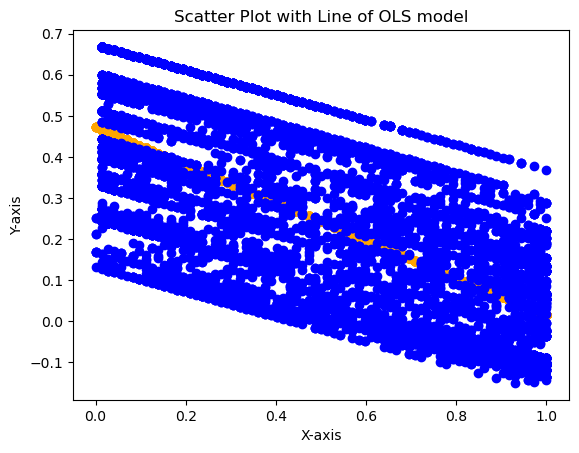

In [ ]:
# ols_pred
X_p = add_constant(X_train)
# # Y_p = y_train
ols_p = ols_m.predict(X_p)
# import matplotlib.pyplot as plt


# pd.concat([X_train['Contract_Oneyear'],ols_p], axis=1)

slope, intercept = np.polyfit(X_train['tenure'],y_train, 1)
line = slope * X_train['tenure'] + intercept
# plt.figure(1)
plt.scatter(X_train['tenure'],line,c='orange')
# plt.scatter(X_train['tenure'],ols_p,c='blue')

# plt.plot(X_train['tenure'], line, color='red', label='Line of OLS orediction')
# plt.plot(X_train['tenure'], ols_p, color='blue', label='Line of OLS orediction')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Line of OLS model')
plt.show()


# X_train['tenure']



In [128]:
ols_p

1668    0.089188
4843    0.409597
5154    0.499437
4400    0.172382
4884    0.481547
          ...   
655     0.329645
5372    0.173902
730    -0.005196
5826    0.667694
70      0.447327
Length: 5634, dtype: float64

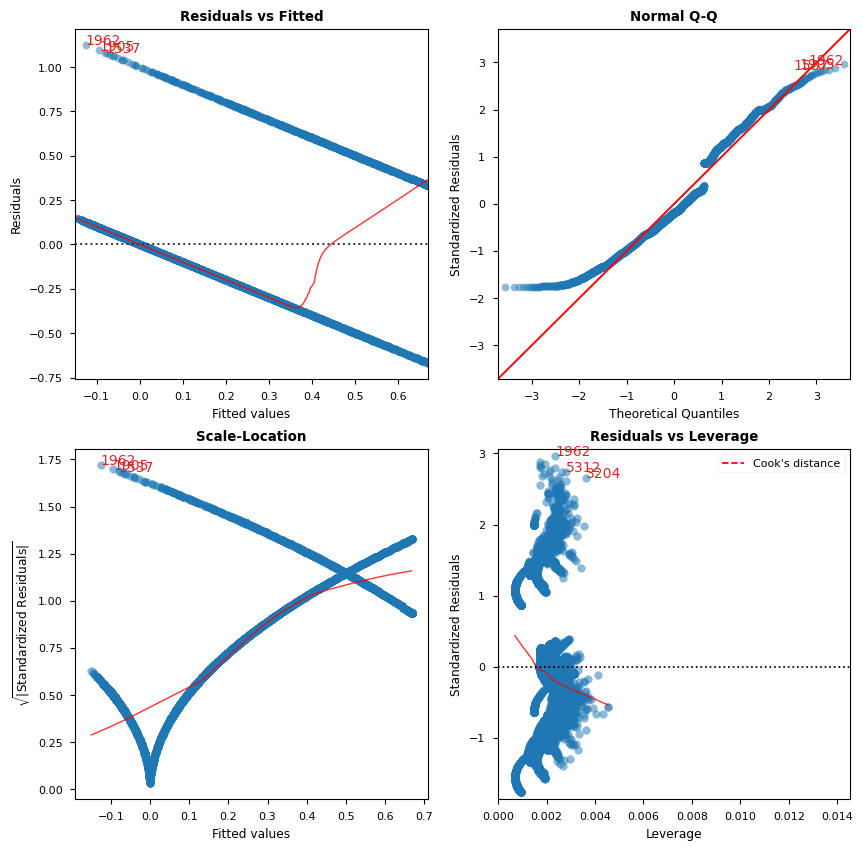

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\o.eltahir\AppData\Local\Temp\ipykernel_48552\2943054620.py", line 2, in <module>
    vif, fig, ax = cls()
                   ^^^^^
  File "c:\personal\Potsdam\masters\winse_24-25\AIBAS\AI-CPS\code\LinearRegDiagnostic.py", line 124, in __call__
  File "c:\personal\Potsdam\masters\winse_24-25\AIBAS\AI-CPS\code\LinearRegDiagnostic.py", line 292, in vif_table
    """
        
NameError: name 'pd' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\IP

In [86]:
cls = LinearRegDiagnostic(ols_m)
vif, fig, ax = cls()
# fig.savefig('data/UE_04_App2_DiagnosticPlots.pdf')
print(vif)

In [43]:
df_encoded.quantile(0.75) 

tenure                                   55.0
Churn                                     1.0
InternetService_DSL                       1.0
InternetService_Fiberoptic                1.0
InternetService_No                        0.0
OnlineSecurity_No                         1.0
OnlineSecurity_Nointernetservice          0.0
OnlineSecurity_Yes                        1.0
TechSupport_No                            1.0
TechSupport_Nointernetservice             0.0
TechSupport_Yes                           1.0
Contract_Month-to-month                   1.0
Contract_Oneyear                          0.0
Contract_Twoyear                          0.0
PaymentMethod_Banktransfer(automatic)     0.0
PaymentMethod_Creditcard(automatic)       0.0
PaymentMethod_Electroniccheck             1.0
PaymentMethod_Mailedcheck                 0.0
Name: 0.75, dtype: float64